# Initial exploration of the ENCODE Mouse ChIP-seq and RNA-seq datasets.

In [1]:
import pandas as pd
import glob
import math
import os
import io
import requests
import urllib
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess

## Download Metadata file and process. 

In [2]:
# Proxy settings
http_proxy  = "http:proxy.swmed.edu:3128"
https_proxy  = "http:proxy.swmed.edu:3128"
proxy_dict = {
              "http"  : http_proxy,
              "https" : https_proxy
            }

# Get all metadata for Mouse ChIP-seq and polyA mRNA-seq
mouse_metadata_url = "https://www.encodeproject.org/metadata/type=Experiment&status=released&assembly=mm10/metadata.tsv"
mouse_metadata_file = requests.get(mouse_metadata_url, proxies=proxy_dict).content

mouse_metadata_df = pd.read_csv(io.StringIO(mouse_metadata_file.decode('utf-8')),sep='\t', low_memory=False)

### Define getting files based on assay, file type and output type

In [3]:
def get_tupes(df, assay_target, output_type, file_type):
    meta_tups = []

    for r in df.iterrows():
        
        # Define biosample varibles
        biosample_type = r[1]['Biosample type']
        biosample_treatment = r[1]['Biosample treatments']
        biosample_term = '-'.join(r[1]['Biosample term name'].split(' '))
        biosample_age = r[1]['Biosample Age'].split(' ')[0]
        biosample_age_units = r[1]['Biosample Age'].split(' ')[-1]
        biosample_stage = r[1]['Biosample life stage']
        
        # Define Experiment varibles
        bio_rep = r[1]['Biological replicate(s)']
        exp_acc = r[1]['Experiment accession']
        file_acc = r[1]['File accession']
        url = r[1]['File download URL']
        output = r[1]['Output type']
        status = r[1]['File Status']
        file_format = r[1]['File format']
        audit = r[1]['Audit ERROR']
        assay = r[1]['Assay']
        
        # Check biosample type
        if biosample_type not in ['tissue', 'primary cell', 'stem cell']:
            continue
        
        # Set age
        if biosample_age not in ['unknown']:
            if biosample_age_units == 'week' and biosample_stage in ['postnatal', 'adult']:
                age = 'P{}w'.format(r[1]['Biosample Age'].split(' ')[0])
            elif biosample_age_units == 'day' and biosample_stage in ['postnatal']:
                age = 'P{}d'.format(r[1]['Biosample Age'].split(' ')[0])
            elif biosample_age_units == 'day' and biosample_stage in ['embryonic']:
                age = 'e{}d'.format(r[1]['Biosample Age'].split(' ')[0])
            elif biosample_age_units == 'week' and biosample_stage in ['embryonic']:
                age = 'e{}d'.format(r[1]['Biosample Age'].split(' ')[0])
        else:
            age = biosample_age
        
        # Filter ages
        if age in ['P10-12w', 'P24w']:
            continue
        
        # Filter out low read depth
        if audit in ["extremely low read depth"]:
            continue
        
        # Filter for released files
        if status != 'released':
            continue
            
        # Define Experiment target
        if assay_target == 'RNA-seq':
            target = assay
        elif assay == 'ChIP-seq':
            target = r[1]['Experiment target'].split('-')[0]
        else:
            continue

        
        # Make Tuple
        if output == output_type and file_format == file_type and target == assay_target:
            bio_rep = bio_rep.replace(', ', '-',1)
            meta_tups.append((target,url,file_acc,bio_rep.replace(', ', '-',1),status,biosample_type,'{}_{}_rep{}_{}_{}_{}'.format(biosample_term,age,bio_rep.replace(', ', '-',1),target,file_acc,exp_acc),'{}_{}'.format(biosample_term,age)))
  
    return meta_tups

### Filter for ChIP-seq H3K27ac Alignments and Replicated Peaks

In [4]:
chip_align_tups = get_tupes(mouse_metadata_df, 'H3K27ac', 'alignments', 'bam')

In [5]:
chip_peaks_tups = get_tupes(mouse_metadata_df, 'H3K27ac', 'replicated peaks','bed narrowPeak')

### Filter for RNA-seq Transcript quantifications

In [6]:
rna_quant_tups = get_tupes(mouse_metadata_df, 'RNA-seq', 'transcript quantifications', 'tsv')

### Filter for Biosamples and Age that have RNA-seq and H3K27ac data

In [7]:
# Make Pandas Dataframes
columns = ['Target', 'URL', 'File Accession', 'Rep', 'Status', 'Type', 'Experiment', 'Age_tissue']
chip_align_df = pd.DataFrame(chip_align_tups, columns=columns)
chip_peaks_df = pd.DataFrame(chip_peaks_tups, columns=columns)
rna_quant_df = pd.DataFrame(rna_quant_tups, columns=columns)

# Define Unique Sets
unique_chip_align = set(chip_align_df['Age_tissue'])
unique_chip_peaks = set(chip_peaks_df['Age_tissue'])
unique_rna_quant = set(rna_quant_df['Age_tissue'])

In [8]:
# Length of ChIP-seq Alignments
len(unique_chip_align)

88

In [9]:
# Length of ChIP-Peaks
len(unique_chip_peaks)

88

In [10]:
# Length of RNA-seq Transcript Quantifications
len(unique_rna_quant)

140

In [11]:
# Intersect ChIP-seq Alignments and Peaks
unique_chip = set(unique_chip_peaks & unique_chip_align )

In [12]:
# Intersect RNA-seq and ChIP-seq
unique_experiments = set(unique_chip & unique_rna_quant)
len(unique_experiments)

88

In [14]:
# Filter for rows only matching Unique Experiments
chip_align_filter_df = chip_align_df[chip_align_df['Age_tissue'].isin(unique_experiments)]
chip_peaks_filter_df = chip_peaks_df[chip_peaks_df['Age_tissue'].isin(unique_experiments)]
rna_quant_filter_df = rna_quant_df[rna_quant_df['Age_tissue'].isin(unique_experiments)]

In [15]:
# Show what data is available for each cell type 
def avail_data(experiments):
    cell_types = set([i.split('_', 1)[0] for i in experiments])
    age = sorted(set([i.split('_', 1)[1] for i in experiments]))
    experiment_df = pd.DataFrame(0,index=cell_types,columns=age)

    for i in experiments:
        cell_type = i.split('_', 1)[0]
        age = i.split('_', 1)[1] 
        experiment_df.loc[cell_type, age] = 1
    
    sb.set_context('paper',font_scale=1.8)
    sb.heatmap(experiment_df, vmin=0, vmax=1, cmap="Blues")
    return experiment_df
    

In [16]:
# Seperate by type 
experiments_tissue = chip_peaks_filter_df[chip_peaks_filter_df['Type'] == 'tissue']
experiments_primarycell = chip_peaks_filter_df[chip_peaks_filter_df['Type'] == 'primary cell']
experiments_stemcell = chip_peaks_filter_df[chip_peaks_filter_df['Type'] == 'stem cell']

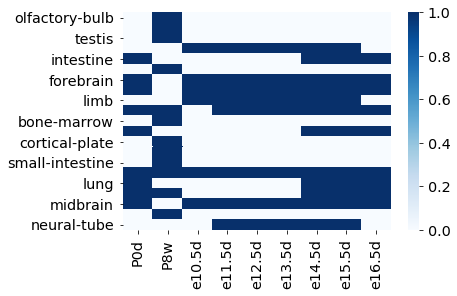

In [17]:
# Graph Tissues
experiments_tissue_df = avail_data(set(experiments_tissue['Age_tissue']))

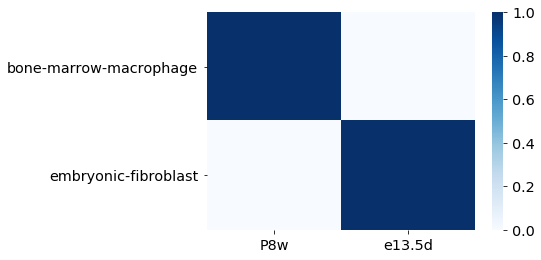

In [18]:
# Graph Primary Cells
experiments_primarycell_df = avail_data(set(experiments_primarycell['Age_tissue']))

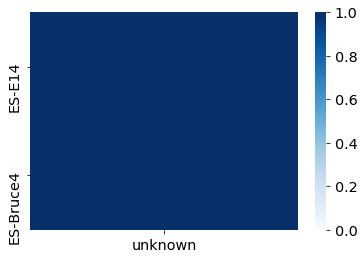

In [19]:
# Graph Stem Cells
experiments_stemcell_df = avail_data(set(experiments_stemcell['Age_tissue']))